<a href="https://colab.research.google.com/github/xiekg2020/DL_test/blob/main/helmet_detection_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Make sure you're using TensorFlow 1.15:**

In [92]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

# **Build the TF1 Object Detection API:**

In [93]:
! pip install tf_slim
! git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [94]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/'
os.environ['PYTHONPATH'] += ':/content/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection/utils/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection'

In [95]:
! apt-get install protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [96]:
%cd models/research
# Compile all the protobuf dependencies
! protoc object_detection/protos/*.proto --python_out=.
# Set up and install the object detection API
! cp object_detection/packages/tf1/setup.py .
! python -m pip install .
# Run a test to make sure setup is correct
! python object_detection/builders/model_builder_test.py

/content/output_ssdlite_mobiledet_hard_hat/models/research
Processing /content/output_ssdlite_mobiledet_hard_hat/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1658478 sha256=e98155a895aebf65cbbb35f8ab358cf598c2d7390de3d1596510fe2afbffd950
  Stored in directory: /tmp/pip-ephem-wheel-cache-1js0xs_u/wheels/93/7e/4b/81e92f565b93aee233f41f0ce7f3e7d79dfc26e5eee0463beb
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


# **Export the trained model**

In [97]:
%cd /content/
OUTPUT_DIR = '/content/output_ssdlite_mobiledet_hard_hat'
! mkdir $OUTPUT_DIR
! echo "0 Head" >> "$OUTPUT_DIR/labels_2.txt"
! echo "1 Helmet" >> "$OUTPUT_DIR/labels_2.txt"
! echo "2 Person" >> "$OUTPUT_DIR/labels_2.txt"

%cd $OUTPUT_DIR

# upload labels.txt, frozen_inference_graph.pb, ssdlite_mobiledet_hard_hat.tflite here
from google.colab import files
local_files=files.upload()

/content
mkdir: cannot create directory ‘/content/output_ssdlite_mobiledet_hard_hat’: File exists
/content/output_ssdlite_mobiledet_hard_hat


# **Evaluate the trained model**

In [98]:
! mkdir /content/validate_img
! cd /content/validate_img
! wget https://live.staticflickr.com/7739/17600110122_d2e7bc55cc_n.jpg -O /content/validate_img/image_1.jpg
! wget https://live.staticflickr.com/4274/34553881773_5731624345_n.jpg -O /content/validate_img/image_2.jpg
! wget https://live.staticflickr.com/2085/2276914329_97bb3fa820_n.jpg -O /content/validate_img/image_3.jpg
! wget https://live.staticflickr.com/5253/5501352212_35c7c4706d_n.jpg -O /content/validate_img/image_4.jpg
! wget https://live.staticflickr.com/2665/3902943422_f2c6317cf8_n.jpg -O /content/validate_img/image_5.jpg
! wget https://live.staticflickr.com/5262/5670134981_47d025cc7c_w.jpg -O /content/validate_img/image_6.jpg

mkdir: cannot create directory ‘/content/validate_img’: File exists
--2021-07-16 08:59:30--  https://live.staticflickr.com/7739/17600110122_d2e7bc55cc_n.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 13.226.180.96, 2600:9000:2211:7c00:0:5a51:64c9:c681, 2600:9000:2211:bc00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|13.226.180.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/content/validate_img/image_1.jpg’

/content/validate_i     [ <=>                ]  34.61K  --.-KB/s    in 0.004s  

2021-07-16 08:59:31 (8.38 MB/s) - ‘/content/validate_img/image_1.jpg’ saved [35436]

--2021-07-16 08:59:31--  https://live.staticflickr.com/4274/34553881773_5731624345_n.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 13.226.180.96, 2600:9000:2211:7c00:0:5a51:64c9:c681, 2600:9000:2211:bc00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)

Evaluating: /content/validate_img/image_1.jpg
Evaluating: /content/validate_img/image_2.jpg
Evaluating: /content/validate_img/image_3.jpg
Evaluating: /content/validate_img/image_4.jpg
Evaluating: /content/validate_img/image_5.jpg
Evaluating: /content/validate_img/image_6.jpg


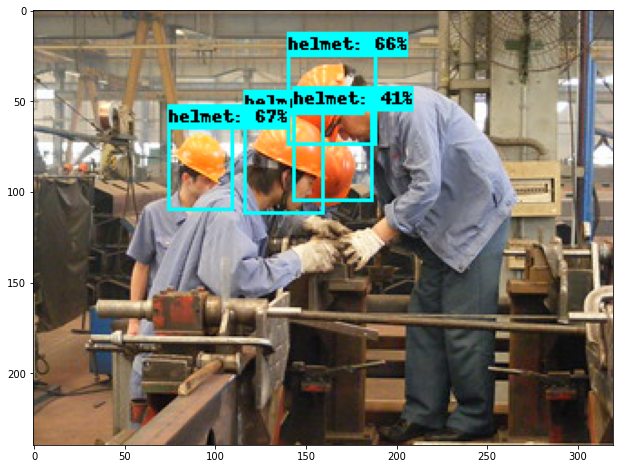

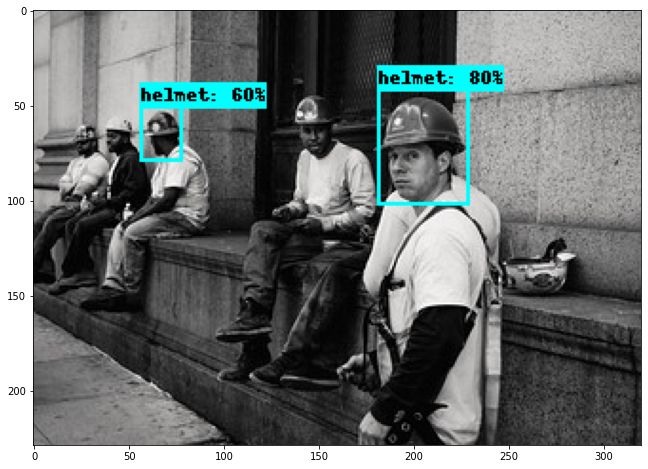

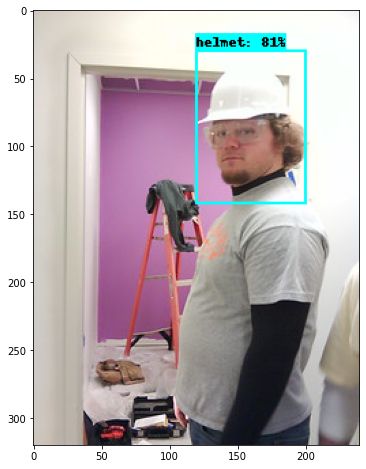

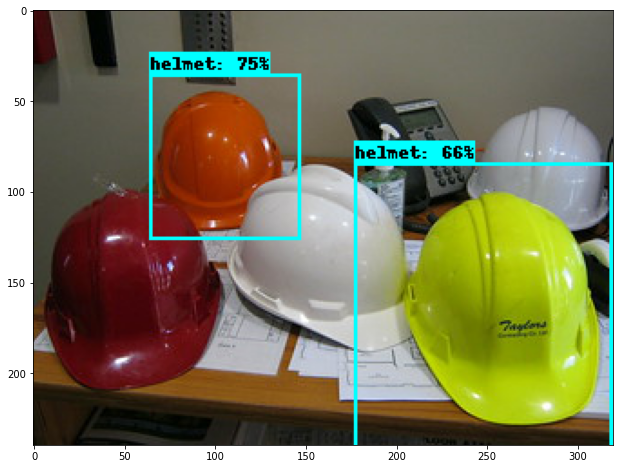

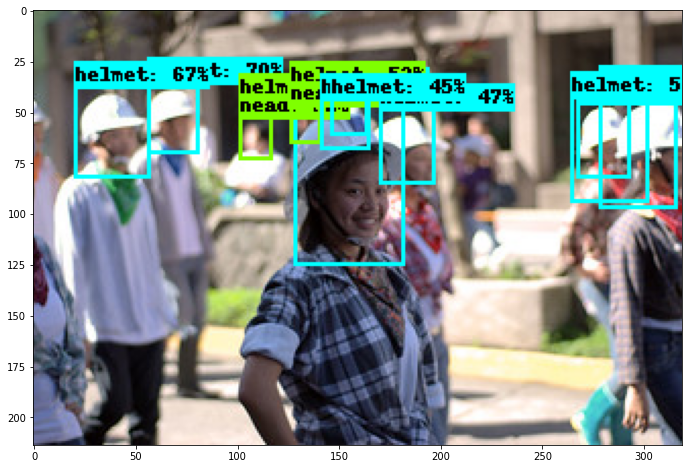

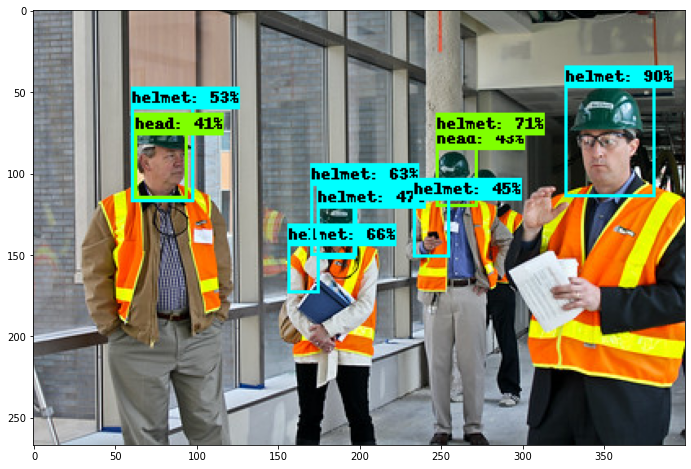

In [99]:
# Do a Quick Evaluation on the inference graph model.
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(OUTPUT_DIR+"/frozen_inference_graph.pb", 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loads labels
label_map = label_map_util.load_labelmap('/content/output_ssdlite_mobiledet_hard_hat/labels.txt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=3, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

test_image_path = [os.path.join('/content/validate_img', 'image_{}.jpg'.format(i)) for i in range(1, 7)]
for image_path in test_image_path:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
  # Run inference.
  output_dict = run_inference(detection_graph, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.4,
      line_thickness=2)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

# **Evaluate the TFlite model**

Evaluating: /content/validate_img/image_1.jpg
Helmet 84.375%
Helmet 66.40625%
Helmet 66.40625%
Helmet 38.671875%
Helmet 38.671875%
Helmet 36.71875%
Helmet 33.59375%
Helmet 33.59375%
Helmet 33.59375%
Helmet 28.515625%


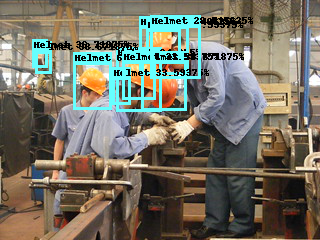

Evaluating: /content/validate_img/image_2.jpg
Helmet 80.078125%
Helmet 63.28125%
Helmet 36.71875%
Helmet 33.59375%
Helmet 33.59375%
Helmet 31.640625%
Helmet 31.640625%
Helmet 30.078125%
Helmet 26.953125%
Helmet 26.953125%


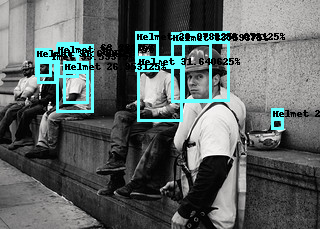

Evaluating: /content/validate_img/image_3.jpg
Helmet 81.25%
Person 28.515625%
Person 21.484375%
Helmet 17.578125%
Helmet 17.578125%
Helmet 16.796875%
Helmet 15.625%
Helmet 13.671875%
Person 13.671875%
Helmet 12.890625%


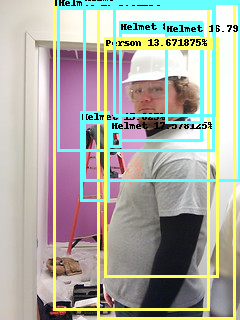

Evaluating: /content/validate_img/image_4.jpg
Helmet 74.609375%
Helmet 66.40625%
Helmet 31.640625%
Helmet 31.640625%
Helmet 28.515625%
Helmet 28.515625%
Helmet 25.390625%
Helmet 22.65625%
Person 21.484375%
Helmet 21.484375%


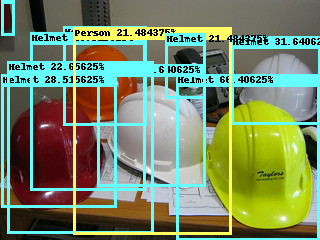

Evaluating: /content/validate_img/image_5.jpg
Helmet 69.921875%
Helmet 66.40625%
Helmet 66.40625%
Helmet 66.40625%
Helmet 61.328125%
Helmet 53.90625%
Helmet 53.90625%
Helmet 50.0%
Helmet 48.046875%
Helmet 46.09375%


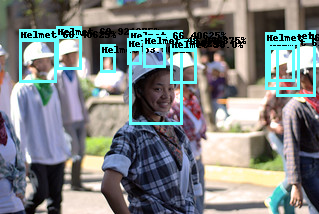

Evaluating: /content/validate_img/image_6.jpg
Helmet 89.453125%
Helmet 71.484375%
Helmet 66.40625%
Helmet 64.84375%
Helmet 63.28125%
Helmet 46.09375%
Head 38.671875%
Helmet 36.71875%
Helmet 35.15625%
Helmet 33.59375%


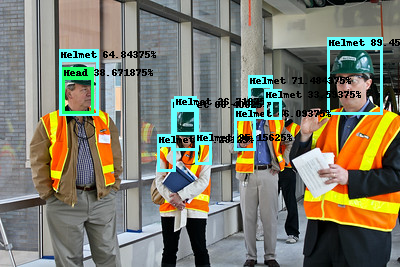

In [136]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = tf.lite.Interpreter(OUTPUT_DIR + '/ssdlite_mobiledet_hard_hat.tflite')
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()

  boxes= interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  num_detections = interpreter.get_tensor(output_details[3]['index'])[0]

  return boxes, classes, scores

test_image_paths = [os.path.join('/content/validate_img', 'image_{}.jpg'.format(i)) for i in range(1, 7)]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.array(resized_image.getdata()).reshape((height, width, 3)).astype(np.uint8)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  # Draw results on image
  colors = {0:(25, 255, 102), 1:(102, 255, 255), 2:(255,255,100)}
  labels = read_label_file(OUTPUT_DIR + '/labels_2.txt')
  for i in range(len(boxes)):
    if scores[i] > 0.1:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      print(text)
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)

# **Real-time detection**

In [125]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [126]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [127]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 320, 320);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 320; //video.videoWidth;
      captureCanvas.height = 320; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [144]:

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([height, width, 4], dtype=np.uint8)
    input_tensor = np.expand_dims(frame, axis=0)
    # Run inference
    boxes, classes, scores = run_inference(interpreter, input_tensor)

    for i in range(len(boxes)):
      if scores[i] > .5:
        ymin = int(max(1, (boxes[i][0] * 320)))
        xmin = int(max(1, (boxes[i][1] * 320)))
        ymax = int(min(image_height, (boxes[i][2] * 320)))
        xmax = int(min(image_width, (boxes[i][3] * 320)))

        bbox_array = cv2.rectangle(bbox_array, (xmin, ymin), (xmax, ymax), colors[int(classes[i])], 1)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(labels[int(classes[i])], float(scores[i])),
                        (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.4,
                        colors[int(classes[i])], 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>